In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

import warnings

warnings.filterwarnings("ignore")

# Nettoyage des données

In [3]:
#fonction qui importe un fichier csv et renvoie un dataframe

def importer_csv(nom_fichier, chemin):
    chemin_complet = chemin  + nom_fichier 
    dataframe = pd.read_csv(chemin_complet, sep='\t')
    return dataframe

In [4]:
#fonction qui supprime les colonnes vides et des lignes doublons

def supprimer_col_vides_doublons(df):
    df.dropna(axis=1, how='all', inplace=True)
    df.drop_duplicates()
    
    return df

In [5]:
def suppression_col_correlees(df, seuil_correlation):
    #création d'un dataframe quantitatif
    df_quantitatif = pd.DataFrame()

    for colonne in df.columns:
        if pd.api.types.is_numeric_dtype(df[colonne]):
            df_quantitatif[colonne] = df[colonne]
            
    # Calculer la matrice de corrélation
    matrice_correlation = df_quantitatif.corr()

    # Identifier les paires de colonnes corrélées
    colonnes_correlees = set()
    for i in range(len(matrice_correlation.columns)):
        for j in range(i):
            if abs(matrice_correlation.iloc[i, j]) >= seuil_correlation:
                colonne_i = matrice_correlation.columns[i]
                colonne_j = matrice_correlation.columns[j]
                colonnes_correlees.add((colonne_i, colonne_j))

     # Supprimer la première colonne de chaque paire corrélée
    for colonne1, colonne2 in colonnes_correlees:
        df.drop(columns=colonne1, inplace=True)
    
    return df

In [6]:
#fonction qui ne garde que les colonnes pertinentes

def selection_colonnes(df):
    #creation de la liste des variables, on y insérant des variables utiles vis à vis de l'analyse
    variables = ['product_name', 'brands','pnns_groups_1', 'pnns_groups_2', 'main_category_fr', 'nutrition_grade_fr']
    
    #liste de toutes les colonnes en rapport avec les valeurs nutritionnelles
    val_nutri = [col for col in df.columns if col.endswith('_100g')]
    
    #suppression de l'empreinte carbone qui n'affecte pas la valeur nutritionelle, ainsi que le nutriscore UK
    try:
        val_nutri.remove('carbon-footprint_100g')
    except KeyError:
        print('colonne inexistente')
    try:
        val_nutri.remove('nutrition-score-uk_100g')
    except KeyError:
        print('colonne inexistente')
        
    variables = variables + val_nutri
    
    #ne garder que ces variables dans le dataframe
    df = df[variables]
    #liste des colonnes avec +60% de valeurs nulles
    colonnes_a_supprimer = df[val_nutri].columns[round(df[val_nutri].isna().mean()*100,1)> 60]
    
    #suppression de ces colonnes vides ou presque
    df = df.drop(columns=colonnes_a_supprimer)
    
    #suppression d'une colonne si +0.85 de corrélation avec une autre
    df = suppression_col_correlees(df, 0.85)
    
    return df



In [7]:
def remplacer_na_100g_mediane(df, liste_colonnes):
    myDict =  {i: df[liste_colonnes][df['main_category_fr'] == i].median() for i in df['main_category_fr'].unique()}
    
    for i in df['main_category_fr'].unique():
        df.loc[df['main_category_fr']== i, liste_colonnes] = df[df['main_category_fr']== i ][liste_colonnes].fillna(df[df['main_category_fr'] == i][liste_colonnes].median()) 
    
    return df

In [8]:
def remplacer_na_knn_imputer(df, col):
    # Convertir la colonne catégorielle en valeurs numériques
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
    # Sélectionner les colonnes numériques pour l'imputation
    colonnes_numeriques = df.select_dtypes(include=['int', 'float']).columns
    df_numerique = df[colonnes_numeriques]
    
    # Appliquer le KNNImputer
    imputer = KNNImputer(n_neighbors=2)
    df_numerique_imputed = pd.DataFrame(imputer.fit_transform(df_numerique), columns=colonnes_numeriques)
    
    # Inverser la transformation sur la colonne catégorielle
    df_numerique_imputed[col] = le.inverse_transform(df_numerique_imputed[col].astype(int))
    
    # Réintégrer les colonnes imputées dans le DataFrame d'origine
    df_imputed = df.copy()
    df_imputed[colonnes_numeriques] = df_numerique_imputed
    
    return df_imputed

In [9]:
def gerer_valeurs_manquantes(df):
    
    #suppression des lignes où le nom du produit n'est pas renseigné
    df = df.dropna(subset=['product_name'])
    
    col_100g = [col for col in df.columns if col.endswith('_100g')]
    
    #remplacer des Nan par la médiane de la colonne
    df = remplacer_na_100g_mediane(df, col_100g)
    
    #remplacer nutriscore A - E avec KNN imputer
    #df = remplacer_na_knn_imputer(df, 'nutrition_grade_fr')
    
    return df

In [10]:
def valeurs_aberrantes(df):
    df = df[(df['nutrition-score-fr_100g'] >= -15) & (df['nutrition-score-fr_100g'] <= 40)]
    
    df = df[(df['energy_100g'] < 4000)]
    
    # Sélectionner les colonnes finissant par "100g" sauf "energy_100g"
    colonnes_a_selectionner = [col for col in df.columns if col.endswith('100g') and col != 'energy_100g' 
                               and col != 'nutrition-score-fr_100g']
    
    df_val_nutri = df[colonnes_a_selectionner]
    
    mask = ((df_val_nutri > 100) | (df_val_nutri < 0)).any(axis=1)
    
    df.drop(index=df[mask].index, inplace=True)
    return df

In [11]:
#défnition variables

chemin = ''
fichier = 'fr.openfoodfacts.org.products.csv'
nom_csv_export = 'sante_publique.csv'

In [12]:
def main():
    import_librairies()
    df = importer_csv(fichier, chemin)
    df = supprimer_col_vides_doublons(df)
    df = selection_colonnes(df)
    df = gerer_valeurs_manquantes(df)
    df = valeurs_aberrantes(df)
    print(df.shape)
    
    # Exporter le DataFrame dans un fichier CSV
    df.to_csv(chemin + nom_csv_export, index=False)

In [48]:
data = pd.read_csv('sante_publique.csv', sep=",")

In [49]:
data['nutrition_grade_fr'].count()

218212

In [50]:
data['nutrition_grade_fr'].value_counts(normalize=True)

nutrition_grade_fr
d    0.283967
c    0.205846
e    0.193770
a    0.161714
b    0.154703
Name: proportion, dtype: float64

In [53]:
# Colonne que vous voulez imputer
col_to_impute = 'nutrition_grade_fr'

# Extraction des colonnes numériques
numeric_cols = data.select_dtypes(include='number').columns

# Label Encoding pour la colonne catégorielle
label_encoder = LabelEncoder()
data[col_to_impute] = label_encoder.fit_transform(data[col_to_impute])

# Création d'un DataFrame temporaire contenant uniquement la colonne à imputer
temp_df = data[[col_to_impute]].copy()

# KNNImputer
imputer = KNNImputer(n_neighbors=2)
temp_df[[col_to_impute]] = imputer.fit_transform(temp_df[[col_to_impute]])

# Inverser le Label Encoding
temp_df[col_to_impute] = label_encoder.inverse_transform(temp_df[col_to_impute].astype(int))

data.update(temp_df)


In [54]:
data['nutrition_grade_fr'].count()

242437

In [ ]:
data[data['nutrition_grade_fr'] == 'a'].count()

<Axes: >

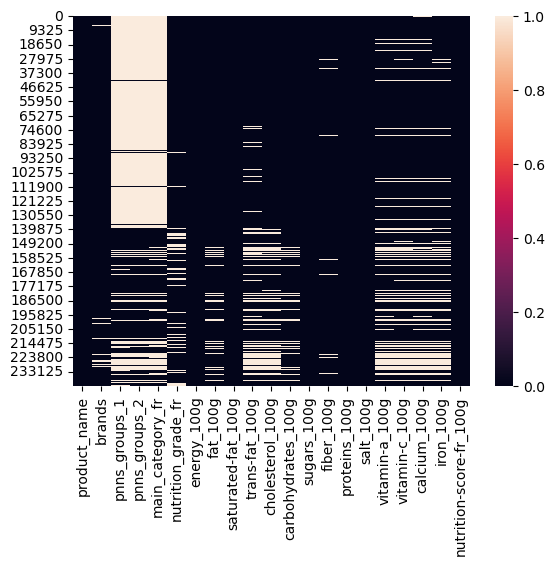

# Analyse